<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap11/11_2_Residual_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tutorial 1c: MNIST1D with Residual Networks**

This tutorial adapts the networks for MNIST1D to use residual connections.

Work through the cells below, running each cell in turn.

The code is adapted from https://github.com/udlbook/udlbook/blob/main/Notebooks/Chap11/11_2_Residual_Networks.ipynb


In [1]:
# Run this if you're in a Colab to make a local copy of the MNIST 1D repository
!git clone https://github.com/greydanus/mnist1d

Cloning into 'mnist1d'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 155 (delta 52), reused 124 (delta 26), pack-reused 0
Receiving objects: 100% (155/155), 6.48 MiB | 30.28 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [2]:
import numpy as np
import os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import mnist1d
import torch.nn.functional as F
import random

In [3]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [4]:
# Load in the data
train_data_x = data['x'].transpose()
train_data_y = data['y']
val_data_x = data['x_test'].transpose()
val_data_y = data['y_test']
# Print out sizes
print("Train data: %d examples (columns), each of which has %d dimensions (rows)"%((train_data_x.shape[1],train_data_x.shape[0])))
print("Validation data: %d examples (columns), each of which has %d dimensions (rows)"%((val_data_x.shape[1],val_data_x.shape[0])))

Train data: 4000 examples (columns), each of which has 40 dimensions (rows)
Validation data: 1000 examples (columns), each of which has 40 dimensions (rows)


## Implementing a Residual Network for MNIST-1D Data

This code snippet outlines the `ResidualNetwork` class, a neural network architecture designed specifically for handling the MNIST-1D dataset. This dataset includes 40 input dimensions corresponding to offsets in the MNIST1D template and 10 output dimensions for the digits.

### Network Dimensions
- `D_i = 40`: Specifies the number of input dimensions (40 offsets in the MNIST1D template).
- `D_o = 10`: Specifies the number of output dimensions (10 digits).

### ResidualNetwork Class
- **Inheritance:** Inherits from `torch.nn.Module`, the base class for all neural network modules in PyTorch.
- **Constructor (`__init__`):**
  - Initializes linear layers to transform the data through the network.
  - `input_size`: Size of the input layer (number of input features).
  - `output_size`: Size of the output layer (number of classes).
  - `hidden_size=100`: Size of the hidden layers, defaulted to 100.
  - Linear layers (`self.linear1`, `self.linear2`, `self.linear3`, `self.linear4`) are defined for transforming data.
  - Prints out the total number of parameters in the model.
- **Count Parameters Method (`count_params`):**
  - Returns the total number of trainable parameters in the model.

### Forward Pass (Implementing Residual Blocks)
- **Function:** `forward`
  - `h1 = self.linear1(x)`: First linear transformation.
  - **First Residual Block:**
    - `h2 = F.relu(self.linear2(h1)) + h1`: Applies a ReLU activation to the output of `linear2` and adds the input of this block (`h1`). This addition of the input to the output is the key component of a residual block, allowing the network to learn identity functions easily and helping to mitigate the vanishing gradient problem.
  - **Second Residual Block:**
    - `h3 = F.relu(self.linear3(h2)) + h2`: Similarly, applies a ReLU activation followed by adding the input of the block (`h2`). This is the second residual connection in the network.
  - The final output is computed with `self.linear4(h3)`.


In [5]:
# There are 40 input dimensions and 10 output dimensions for this data
# The inputs correspond to the 40 offsets in the MNIST1D template.
D_i = 40
# The outputs correspond to the 10 digits
D_o = 10

class ResidualNetwork(torch.nn.Module):
  def __init__(self, input_size, output_size, hidden_size=100):
    super(ResidualNetwork, self).__init__()
    self.linear1 = nn.Linear(input_size, hidden_size)
    self.linear2 = nn.Linear(hidden_size, hidden_size)
    self.linear3 = nn.Linear(hidden_size, hidden_size)
    self.linear4 = nn.Linear(hidden_size, output_size)
    print("Initialized MLPBase model with {} parameters".format(self.count_params()))

  def count_params(self):
    return sum([p.view(-1).shape[0] for p in self.parameters()])

  def forward(self, x):
    h1 = self.linear1(x)
    h2 = F.relu(self.linear2(h1)) + h1  # First residual block
    h3 = F.relu(self.linear3(h2)) + h2  # Second residual block
    return self.linear4(h3)


In [6]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [7]:
#Define the model
model = ResidualNetwork(40, 10)

# Choose cross entropy loss function
loss_function = nn.CrossEntropyLoss()
# Construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# Object that decreases learning rate by half every 20 epochs
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
# Convert data to torch tensors
x_train = torch.tensor(train_data_x.transpose().astype('float32'))
y_train = torch.tensor(train_data_y.astype('long'))
x_val= torch.tensor(val_data_x.transpose().astype('float32'))
y_val = torch.tensor(val_data_y.astype('long'))

Initialized MLPBase model with 25310 parameters


In [8]:
# Load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# Loop over the dataset n_epoch times
n_epoch = 100
# Store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_val = np.zeros((n_epoch))
errors_val = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # Loop over batches
  for i, data in enumerate(data_loader):
    # Retrieve inputs and labels for this batch
    x_batch, y_batch = data
    # Zero the parameter gradients
    optimizer.zero_grad()
    # Forward pass -- calculate model output
    pred = model(x_batch)
    # Compute the loss
    loss = loss_function(pred, y_batch)
    # Backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_val = model(x_val)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_val_class = torch.max(pred_val.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_val[epoch]= 100 - 100 * (predicted_val_class == y_val).float().sum() / len(y_val)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_val[epoch]= loss_function(pred_val, y_val).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  val loss {losses_val[epoch]:.6f}, percent error {errors_val[epoch]:3.2f}')

  # Tell scheduler to consider updating learning rate
  scheduler.step()

Epoch     0, train loss 1.640437, train error 61.20,  val loss 1.743309, percent error 67.30
Epoch     1, train loss 1.127049, train error 42.15,  val loss 1.301472, percent error 50.50
Epoch     2, train loss 0.974488, train error 36.88,  val loss 1.180154, percent error 45.10
Epoch     3, train loss 0.886016, train error 33.47,  val loss 1.179382, percent error 45.90
Epoch     4, train loss 0.850890, train error 31.85,  val loss 1.226875, percent error 46.00
Epoch     5, train loss 0.756187, train error 27.70,  val loss 1.172382, percent error 41.60
Epoch     6, train loss 0.724455, train error 26.18,  val loss 1.233524, percent error 42.40
Epoch     7, train loss 0.676716, train error 25.80,  val loss 1.196606, percent error 41.00
Epoch     8, train loss 0.601522, train error 21.68,  val loss 1.202768, percent error 40.20
Epoch     9, train loss 0.502052, train error 17.88,  val loss 1.176953, percent error 38.10
Epoch    10, train loss 0.430322, train error 15.47,  val loss 1.22925

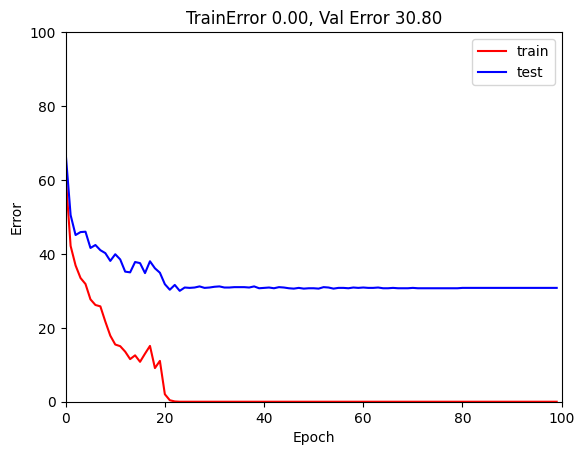

In [9]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_val,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Val Error %3.2f'%(errors_train[-1],errors_val[-1]))
ax.legend()
plt.show()

The primary motivation of residual networks is to allow training of much deeper networks.   

TODO: Try running this network with and without the residual connections.  Does adding the residual connections change the performance?